In [1]:
from src import *

0.05305164769729845
1/D_R*beta: 75.88388052149259


### Export

In [6]:
def save_output(time, Rs_sol, ps_sol, N, Omega, custom_name = "name"):
    if custom_name == "name":
        f = open(f"outputOmega{Omega}N{N}.txt", "w")
    else:
        f = open(f"{custom_name}.txt", "w")
    for i in range(0, 50000, 10):
        f.write("ITEM: TIMESTEP"+ '\n')
        f.write(str(time[i])+ '\n')
        f.write("ITEM: NUMBER OF ATOMS"+ '\n')
        f.write(str(N)+ '\n')
        f.write("ITEM: ATOMS id x y z vx vy vz"+ '\n')
        for j in range(N):
            s = ''
            s += str(j)
            for k in range(3):
                s += ' '
                s += str(Rs_sol[i, j, k])
            #s += ' 0'
            for k in range(3):
                s += ' '
                s += str(ps_sol[i, j, k])
            f.write(s+ '\n')
    f.close()        
    

In [2]:
N = 100
zs = np.random.uniform(0, L, N)
psis = np.random.uniform(0, 2*np.pi, N)
Rs = np.random.triangular(R1 + R, R2 - R, R2 - R, N)
vecs = np.random.normal(size = (N, 3))
R0s = []
p0s = []
kx = np.array([1, 0, 0]) # up vector
k0 = np.array([0, 0, 0]) 
for i in range(N):
    R0s.append([Rs[i] * np.cos(psis[i]), Rs[i] * np.sin(psis[i]), zs[i]])
    p0s.append(vecs[i]/np.linalg.norm(vecs[i]))

In [3]:
ps_sol, Rs_sol, t = solver(0.1, 0.01, kx, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = False)

No tumbling
omega/D_R: 30.660153746057613


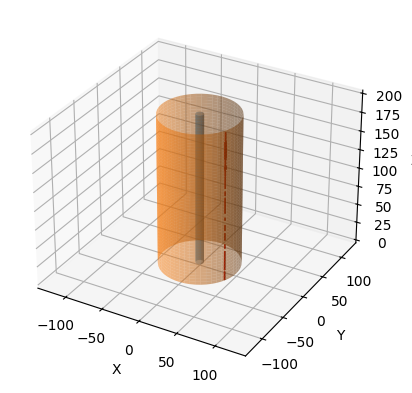

In [4]:
plot_state(Rs_sol[-1, :, :])

In [5]:
pss, Rss, t = solver(5, 0.01, kx, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = False)

Tumbling period: 124.55976395549156
omega/D_R: 1533.0076873028806


In [7]:
save_output(t, Rss, pss, N, 5)

In [62]:
steady = Rss[-40000:-1:100, :, :]
coords = steady.reshape((40000,3))
psi = np.arctan2(coords[:, 1], coords[:, 0])
r = np.linalg.norm(coords[:, :2], axis = 1)

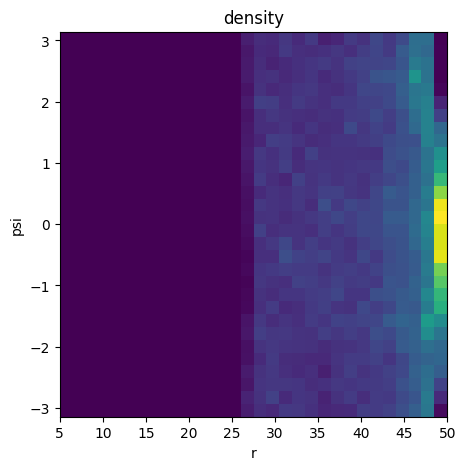

In [71]:
fig, axs = plt.subplots(figsize = (5,5))
axs.hist2d(r, psi, bins = 30, range = [[R1, R2], [-np.pi, np.pi]])
axs.set_xlabel('r')
axs.set_ylabel('psi')
axs.set_title('density')
plt.show()

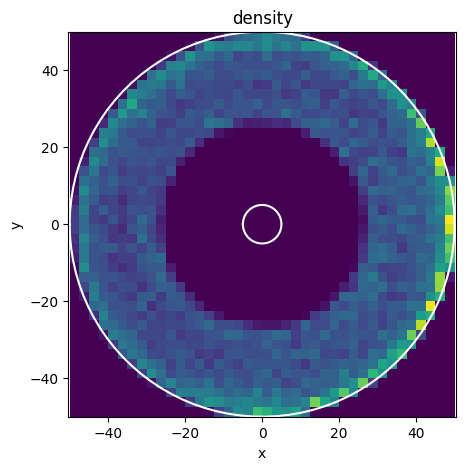

In [64]:
fig, axs = plt.subplots(figsize = (5,5))
axs.hist2d(coords[:, 0], coords[:, 1], bins = 40, range = [[-R2, R2], [-R2, R2]])
axs.axis('equal')
axs.set_xlabel('x')
axs.set_ylabel('y')
axs.set_title('density')
angle = np.linspace(-np.pi, np.pi, 100)
axs.plot(R1 * np.cos(angle), R1 * np.sin(angle), color = 'white')
axs.plot(R2 * np.cos(angle), R2 * np.sin(angle), color = 'white')
#plt.colorbar()
plt.show()

In [116]:
steady = Rss[-40000:-1:100, :, :]
coords = steady.reshape((40000,3))
#coords = Rss[-1, :, :]
#vs = (Rss[-1, :, :] - Rss[-2, :, :]) / 0.1
steady1 = Rss[-40001:-2:100, :, :]
vs = (steady - steady1) / 0.1
vs = vs.reshape((40000,3))
psi = np.arctan2(coords[:, 1], coords[:, 0])
alpha = np.arctan2(vs[:, 1], vs[:, 0])
r = np.linalg.norm(coords[:, :2], axis = 1)
v = np.linalg.norm(vs[:, :2], axis = 1)
v_r = v * np.cos(psi - alpha)
v_phi = v * np.sin(psi - alpha)

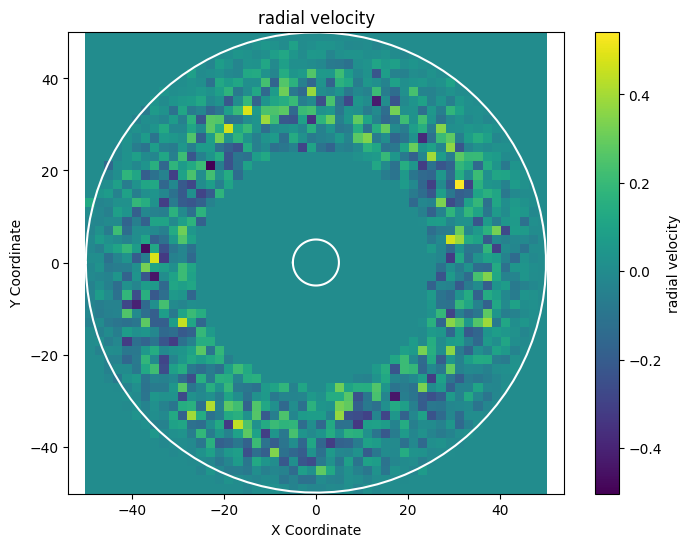

In [140]:
plot_function(coords[:,:2], v_r, grid_size = 50, custom_name = "radial velocity")

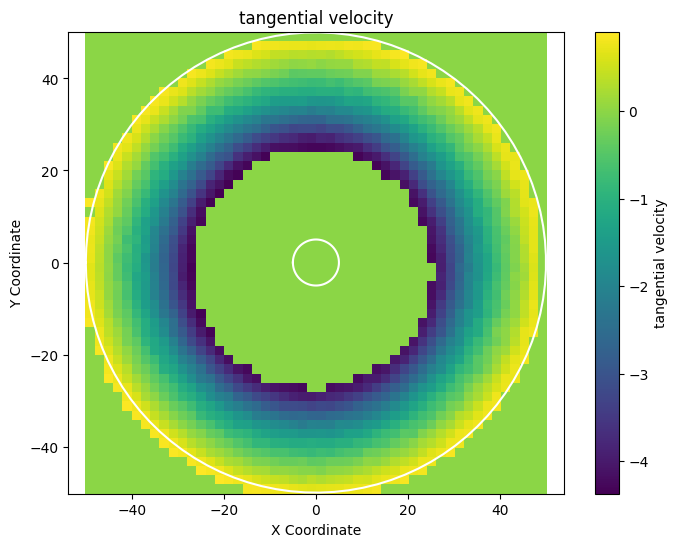

In [141]:
plot_function(coords[:,:2], v_phi, grid_size = 50, custom_name = "tangential velocity")

In [139]:
def plot_function(coordinates, values, grid_size=100, custom_name = "Average value"):
    """
    Plot the average function value over the coordinates on a 2D plot.

    Parameters:
        coordinates (list of tuples): List of (x, y) coordinates.
        values (list of floats): Function values corresponding to each coordinate.
        grid_size (int): Number of grid points in each dimension for averaging.
    """
    # Convert input to numpy arrays
    coordinates = np.array(coordinates)
    values = np.array(values)

    # Create a grid for averaging
    x_min, x_max = coordinates[:, 0].min(), coordinates[:, 0].max()
    y_min, y_max = coordinates[:, 1].min(), coordinates[:, 1].max()
    x_grid = np.linspace(x_min, x_max, grid_size)
    y_grid = np.linspace(y_min, y_max, grid_size)
    xx, yy = np.meshgrid(x_grid, y_grid)

    # Initialize grid for averaged values
    avg_values = np.zeros_like(xx)
    count = np.zeros_like(xx)

    # Compute the average values for each grid cell
    for (x, y), value in zip(coordinates, values):
        i = np.searchsorted(x_grid, x) - 1
        j = np.searchsorted(y_grid, y) - 1

        if 0 <= i < grid_size - 1 and 0 <= j < grid_size - 1:
            avg_values[j, i] += value
            count[j, i] += 1

    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        avg_values = np.divide(avg_values, count, out=np.zeros_like(avg_values), where=count > 0)

    # Plot the results
    plt.figure(figsize=(8, 6))
    #plt.contourf(xx, yy, avg_values, levels=50, cmap='jet')
    plt.pcolormesh(xx, yy, avg_values, cmap='viridis')
    plt.colorbar(label=custom_name)
    #plt.scatter(coordinates[:, 0], coordinates[:, 1], c=values, edgecolor='k', cmap='viridis', label="Data Points")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title(custom_name)
    #plt.legend()
    angle = np.linspace(-np.pi, np.pi, 100)
    plt.plot(R1 * np.cos(angle), R1 * np.sin(angle), color = 'white')
    plt.plot(R2 * np.cos(angle), R2 * np.sin(angle), color = 'white')
    plt.axis('equal')
    plt.show()
